## Acoustic Signal Processing for Bioacoustics
### 01 - Aliasing

In this notebook we look into the issue of aliasing when making outdoor recordings.

Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)

In [2]:
# Firstly let us import several of the packages we will need. 
# If these packages are not available on your machine, you will have to install them first. 

import numpy as np 
from scipy import signal
import sounddevice as sd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import IPython
from IPython.display import Audio, Image
from ipywidgets import interact # interactive plots
%matplotlib ipympl

### From continuous time to discrete time

When recording bioacoustic signals (e.g. bird calls), our goal is to get an accurate discrete representation of the signal. The bioacoustic signal at its source is a continuous-time signal, meaning that for any instance of time, we can obtain the amplitude of that signal. 

When we capture a bioacoustic signal with a microphone, the signal is sampled in time, i.e. at specific instances in time, we take a snapshot of the signal. We can think of this as a switch that you are repeatedly opening and closing, and when the switch is closed, we record the amplitude of the bioacoustic signal. So incomparison to a continuous time signal, we now have a discrete time signal as we only have information at specific instances in time.

As there are also a specific number of bits (e.g. 16-bit, 32-bit) we are constrained to (depending on the recording interface), the amplitude of the signal is also discretized, i.e., it must correspond to a speicfic level defined by the bit sequence. So for instance for a 2-bit recording, there are 4 discrete levels: 00, 01, 10, or 11. In general for an n-bit system, there are $2^{n}$ discrete levels, where higher bits allow for increased resolution.

In this notebook however, we are only concerned about the discretization in time, which we refer to as **sampling**. The key factor to consider in sampling is the **sampling frequency** (Hz) (also called sample rate), which we will denote as $f_{s}$. This corresponds to how fast we are opening and closing that "switch" to take snapshots of the signal. It is related to the sampling period, $T_{s}$, the time between samples (seconds) by $T_{s} = 1/f_{s}$.

Mathematically, we represent discrete-time signals as $y[n]$ for $n = 0, 1, 2, \dots$.
This is actually a short-hand for $y[n.T{s}]$ for $n = 0, 1, 2, \dots$ (but the $T_{s}$ is a bit cumbersome to carry around, so it's usually dropped).

Let's consider a simple sinusoid of 100 Hz as our bioacoustic continuous time signal, and change $T_s$ to see the impact on what the discrete representation of the signal looks like.




<!-- ![title](img/echo_canceller.png) -->

Change the sampling period to see the impact


interactive(children=(FloatSlider(value=0.0001, description='Ts', max=0.01, min=0.0001, step=0.0001), Output()…

<function __main__.update(Ts=0.0001)>

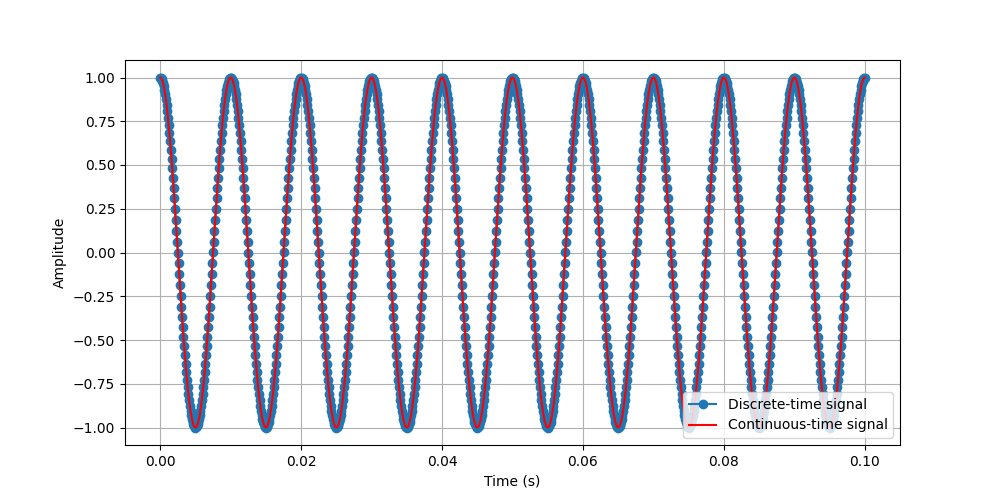

In [3]:
# "Continuous-time signal"
f = 100 # Frequency (Hz)
Tend = 0.1
Ts_c = 0.0001 # Sampling period (s)
tt_c = np.arange(0,Tend+Ts_c,Ts_c) # range of times to plot on x-axis
yy_c = np.cos(2*np.pi*f*tt_c) 


fig, axes = plt.subplots(figsize=(10, 5)) 
line, = axes.plot([],[],'-o', label='Discrete-time signal')
axes.plot(tt_c, yy_c,color='red', label='Continuous-time signal')
axes.set_ylabel('Amplitude', color='k')
axes.set_xlabel('Time (s)', color='k')
# axes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# axes.set_xlim([0, 2])
# axes.set_ylim([-1, 1])
axes.grid()
axes.legend(loc='lower right')


# Custom formatting function
def format_float(value):
    return f'{value:.6f}'  # Format value to display four decimal places


# Create the interactive plot
def update(Ts = 0.0001):
    
    fs = 1/Ts # Sampling Frequency (Hz)
    tt = np.arange(0,Tend+Ts,Ts) # range of times to plot on x-axis
    yy = np.cos(2*np.pi*f*tt) 

    line.set_data(tt, yy)
    
    print('Signal Frequency = '+str(f)+' Hz')
    print('Sampling Period = '+str(np.round(Ts,decimals=4))+' s')
    print('Sampling Frequency = '+str(np.round(fs,decimals=2))+' Hz')
    
print('Change the sampling period to see the impact')
interact(update, Ts = (0.0001,0.01,0.0001), format=format_float) 






### Nyquist-Shannon Sampling Theorem

One thing we can see is that as we increase $T_{s}$, i.e., if there is greater temporal spacing between our discrete samples, or if we were opening and closing the switch at a slower rate, the discrete representation becomes a poorer representation of the true continuous time signal. In fact we even see as $f_{s}$ reaches some value, it looks like the discrete time signal is of a lower frequency than the true 100 Hz signal - this is what we call **aliasing**!.

The **Nyquist-Shannon sampling theroem** gives us the condition under which we avoid this. In fact, $f_{s}$ is above a certain threshold frequency, then we are guaranteed to have all of the information about the signal. The **Nyquist-Shannon sampling theroem** states that:

**The sampling frequency, $f_{s}$ must be greater than or equal to twice the bandwidth, $B$ (Hz) of the signal you are attempting to sample, i.e. $f_{s} \geq 2B$**.

Let's see this in action and then try to understand why it's the case. 
In the following see if you can play a bioacoustic signal that has frequency content beyond 2 kHz but less than 10 kHz. Alternatively, you can do a whistle that increases in frequency (hoping that you can go beyond 2 kHz :)). 


In [4]:
# Run this block and play your signal to record it.
# We are recording at 24 kHz

duration = 3  # seconds
fs = 24000    # Sampling frequency (Hz)
print ('recording...')
whistle = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('recording completed')

recording...
recording completed


Let's take a look at the data. We will also view a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of the data to observe the time-frequency content.

Data shape:  (72000, 1)
Whistle sampled at 24 kHz:


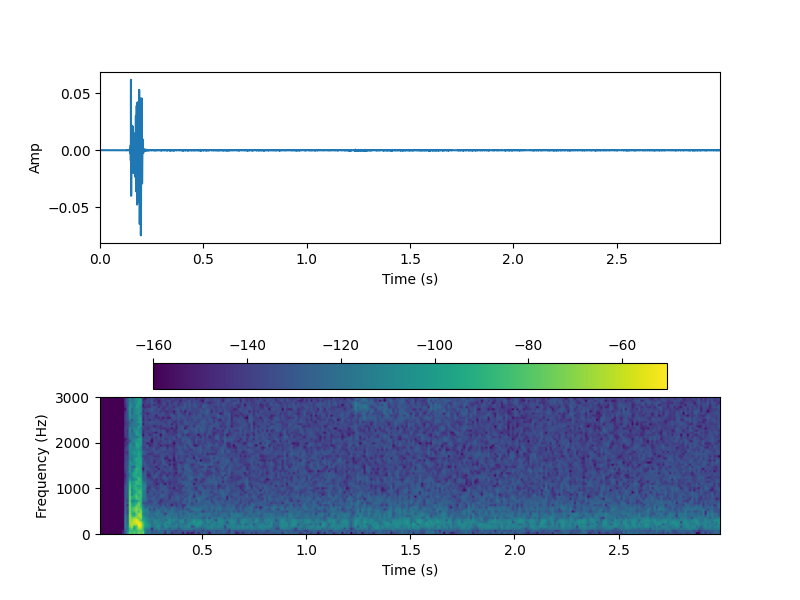

In [6]:
print("Data shape: ", whistle.shape)
print("Whistle sampled at 24 kHz:")
IPython.display.display(Audio(whistle.T, rate=fs))

# Creating the time vector
dt = 1/fs           
N = len(whistle) 
time = np.arange(0,N*dt,dt)  


fig, axes = plt.subplots(2, 1, figsize=(8, 6)) 
fig.subplots_adjust(hspace=0.7) # spacing between figures

axes[0].plot(time,whistle)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim(time[0],time[-1])

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(whistle[:,0], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2 + 1e-16) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"

sp = axes[1].imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_ylim(0,3000)   # Adjust this range if your whistle goes higher!
cb = plt.colorbar(sp,ax=[axes[1]],location='top')


Okay so that should have given you a fairly accurate representation of the signal. What you see in the spectrogram is the brightest area corresponding to the highest acoustic pressures recorded. You will perhaps also see changing frequency content of your signal. The key point to take away here is that the sound of the signal that you recorded (i.e. the one you can listen to above) sounds just like the sound you produced. Apart from the signal quality, the frequency content of the whistle has been captured accurately. This is because the maximum frequency I asked you to produce was 10 kHz (hence the effective bandwidth, $B \leq 10$ kHz) and $f_{s} = 24$ kHz, hence the Nyquist-Shannon sampling theroem has been satisfied.


### Inducing aliasing

So now let's try to delibrately violate the Nyquist-Shannon sampling theroem. After executing the cell below record the same bioacoustic signal as before, but now let's acquire the signal with a much lower sampling frequency.

In [7]:
duration = 3  # seconds
fs = 3000    # Sampling frequency (Hz)
print ('recording...')
whistle = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')


recording...
finished recording


Data shape:  (9000, 1)
Whistle sampled at 3 kHz:


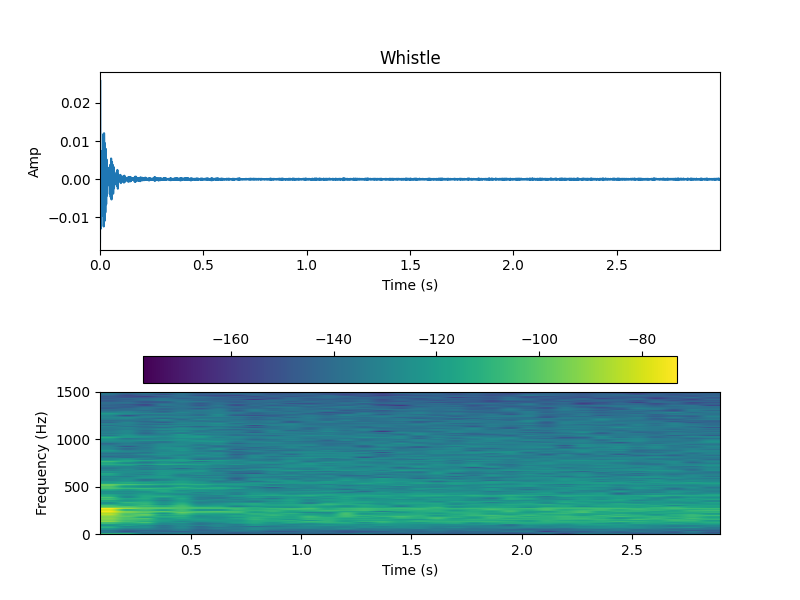

In [8]:
print("Data shape: ", whistle.shape)
print("Whistle sampled at 3 kHz:")
IPython.display.display(Audio(whistle.T, rate=fs))

# Need to redefine the time vector since we use a different fs!
dt = 1/fs           
N = len(whistle) 
time = np.arange(0,N*dt,dt)  


fig, axes = plt.subplots(2, 1, figsize=(8, 6)) 
fig.subplots_adjust(hspace=0.6) # spacing between figures

axes[0].plot(time,whistle)
axes[0].set_title('Whistle')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim(time[0],time[-1])

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(whistle[:,0], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"

sp = axes[1].imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
cb = plt.colorbar(sp,ax=[axes[1]],location='top')

Now you should have an appreciation for what just happened if your signal had frequency content beyond $1.5$ kHz. You would have no longer satisfied the Nyquist-Shannon criterion that $f_{s} \geq B$, and hence there is frequency content in your signal that does not correspond to the true sound of the bioacoustic signal you were trying to record.

The take away is that if you sampled at too low of a sampling frequency, the signal content that you think might be there is actually not true, but an artifact created by aliasing! So we need to be careful! How? In many cases, it is important to do some investigation into the source signals you are recording and documented bandwidths of their sound. If that's known, it can certainly help us decide on our sampling frequency to avoid aliasing.  

## But why did aliasing occur?

In the following code, you will see two columns of figures: the left hand column (LHC) relates to the time domain and on the right hand column (RHC), the frequency domain.


In the time domain, we can think of sampling as a process that involves the multiplication of the continuous time signal (first figure on the LHC) an impulse train, i.e., a series of impulses spaced by $T_s$ seconds (second figure on the LHC). The result is the discrete time/sampled signal in the last figure of the LHC.

In the RHC, the first figure shows the frequency spectrum of the continuous time signal. The second figure is the Fourier transform of the impulse train - which is in fact another impulse train, but the samples are however now separated by $f_s = 1/T_s$ Hz. In the frequency domain, a multiplication in the time domain corresponds to a convolution in the frequency domain. The result of that operation is that the frequency spectrum of the continuous time signal is repeated at each of the impulses in the frequency domain impulse train, and recall those impulses are separated at integer multiples of $f_s$. 

In the interactive plot, what you will see is that as you increase $T_{s}$, you decrease $f_{s}$ and so these repeated frequency spectrums begin to overlap with the original frequency spectrum, i.e., **aliasing**, which is unfortunately an irreversible distortion. The plot also makes it evident why the Nyquist-Shannon thereom requires that $fs \geq 2B$, i.e., the sampling frequency must be greater than or equal to the bandwidth of the continuous-time signal.


Change the sampling period to see the impact


interactive(children=(FloatSlider(value=0.001, description='Ts', max=0.01, min=0.001, step=0.0001), Output()),…

<function __main__.plot_impulse_train(Ts=0.001)>

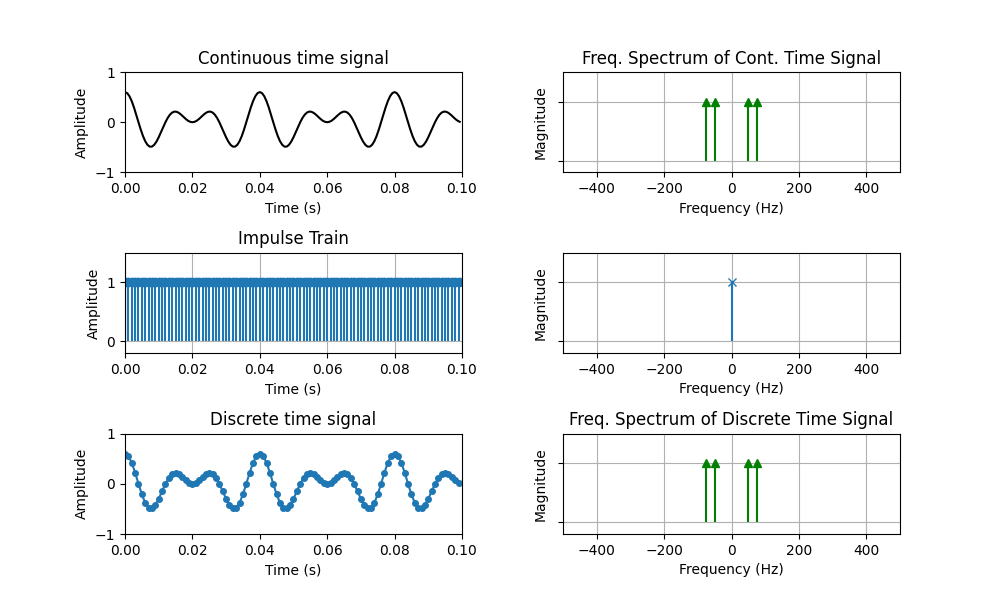

In [9]:
# A few functions...

# Make a simple signal 
def make_signal(f1, f2, time):
    y = 0.3*np.cos(2*np.pi*f1*time) + 0.3*np.cos(2*np.pi*f2*time)
    return y

# This is a helper function to get data to plot for the freq. spectrum of discrete signal
def get_freq_rep(fs, freq_in):
    data = []
    for n in np.arange(-10,  11, 1):
        if n!=0:
            offset = n*fs
            data.append(offset+freq_in)    
    return np.array(data).flatten()


Ts_min = 0.001 # Sampling period (s) (starting value, we will change later)
fs_max = 1/Ts_min
T = 0.1 # total time (seconds)
t = np.arange(0, T, Ts_min)
imp = np.ones(len(t))

# Input Signals
f1 = 50 # Frequency (Hz)
f2 = 75

t_cont = np.arange(0, T, (1/(f2*20))) # make a time with a small sampling period to act as our "continuous signal"
y_cont = make_signal(f1, f2, t_cont)
y_disc = make_signal(f1, f2, t)

fig, axes = plt.subplots(3,2,figsize=(10, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.8)

# "Continuous time" signal
axes[0,0].plot(t_cont,y_cont, color='k')
axes[0,0].set_ylabel('Amplitude', color='k')
axes[0,0].set_xlabel('Time (s)', color='k')
axes[0,0].set_title('Continuous time signal')
axes[0,0].set_xlim([0, T])
axes[0,0].set_ylim([-1, 1])

# Time-Domain Impulse Train
markers, = axes[1,0].plot([],[],ls="none",marker="o")
verts=np.c_[t, np.zeros_like(t), t, imp].reshape(len(t),2,2)
col = LineCollection(verts)
axes[1,0].add_collection(col)
axes[1,0].set_ylabel('Amplitude', color='k')
axes[1,0].set_xlabel('Time (s)', color='k')
axes[1,0].set_title('Impulse Train')
axes[1,0].set_xlim([0, T])
axes[1,0].set_ylim([-0.2, 1.5])
axes[1,0].grid()

# Discrete time signal

line, = axes[2,0].plot(t,y_disc,'-o',markersize=4)
axes[2,0].set_ylabel('Amplitude', color='k')
axes[2,0].set_xlabel('Time (s)', color='k')
axes[2,0].set_title('Discrete time signal')
axes[2,0].set_xlim([0, T])
axes[2,0].set_ylim([-1, 1])




# Frequency Spectrum of continuous time data
freq_input = np.array([-f2, -f1, f1, f2])
freq_input_data = np.ones(len(freq_input))
markers_fd_input, = axes[0,1].plot(freq_input,freq_input_data,ls="none",marker="^", color="g")
verts_fd_input=np.c_[freq_input, np.zeros_like(freq_input), freq_input, freq_input_data].reshape(len(freq_input),2,2)
col_fd_input = LineCollection(verts_fd_input, color="g")
axes[0,1].add_collection(col_fd_input)
axes[0,1].set_xlim([-fs_max//2, fs_max//2])
axes[0,1].set_ylim([-0.2, 1.5])
axes[0,1].yaxis.set_ticklabels([])
axes[0,1].set_ylabel('Magnitude', color='k')
axes[0,1].set_xlabel('Frequency (Hz)', color='k')
axes[0,1].grid()
axes[0,1].set_title('Freq. Spectrum of Cont. Time Signal')


# Freq-Domain Impulse Train
freq = np.arange(-2*fs_max, 3*fs_max, fs_max)
freq_imp = np.ones(len(freq))
markers_fd, = axes[1,1].plot([],[],ls="none",marker="x")
verts_fd=np.c_[freq, np.zeros_like(freq), freq, freq_imp].reshape(len(freq),2,2)
col_fd = LineCollection(verts_fd, ls="solid")
axes[1,1].add_collection(col_fd)
axes[1,1].set_ylabel('Magnitude', color='k')
axes[1,1].yaxis.set_ticklabels([])
axes[1,1].set_xlabel('Frequency (Hz)', color='k')
axes[1,1].set_xlim([-fs_max//2, fs_max//2])
axes[1,1].set_ylim([-0.2, 1.5])
axes[1,1].grid()


# Frequency Spectrum of discrete time data

freq_disc = get_freq_rep(fs_max, freq_input)
freq_disc_data = np.ones(len(freq_disc))
markers_fd_disc, = axes[2,1].plot(freq_disc,freq_disc_data,ls="none",marker="^", color="m")
verts_fd_disc=np.c_[freq_disc, np.zeros_like(freq_disc), freq_disc, freq_disc_data].reshape(len(freq_disc),2,2)
col_fd_disc = LineCollection(verts_fd_disc, color="m")
axes[2,1].add_collection(col_fd_disc)

# showing original spectrum
markers_fd_input2, = axes[2,1].plot(freq_input,freq_input_data,ls="none",marker="^", color="g")
verts_fd_input2=np.c_[freq_input, np.zeros_like(freq_input), freq_input, freq_input_data].reshape(len(freq_input),2,2)
col_fd_input2 = LineCollection(verts_fd_input2, color="g")
axes[2,1].add_collection(col_fd_input2)

axes[2,1].set_xlim([-fs_max//2, fs_max//2])
axes[2,1].set_ylim([-0.2, 1.5])
axes[2,1].yaxis.set_ticklabels([])
axes[2,1].set_ylabel('Magnitude', color='k')
axes[2,1].set_xlabel('Frequency (Hz)', color='k')
axes[2,1].grid()
axes[2,1].set_title('Freq. Spectrum of Discrete Time Signal')



# Define the function that will generate and plot the impulse points

def plot_impulse_train(Ts=Ts_min):
    
    # For time-domain impulses
    # Generate the indices where impulses occur + set values to 1 + update
    t = np.arange(0, T, Ts) # vector spaced by Ts
    imp = np.ones(len(t))
    markers.set_data(t, imp)
    verts=np.c_[t, np.zeros_like(t), t, imp].reshape(len(t),2,2)
    col.set_segments(verts)
    
    # Do the same for freq.
    fs = 1/Ts
    freq = np.arange(-10*fs, 11*fs, fs)    
    freq_imp = np.ones(len(freq))
    markers_fd.set_data(freq, freq_imp)
    verts_fd=np.c_[freq, np.zeros_like(freq), freq, freq_imp].reshape(len(freq),2,2)
    col_fd.set_segments(verts_fd)
    
    # Set data for discrete time signal
    y_disc = make_signal(f1, f2, t)
    line.set_data(t, y_disc)
    
    # Set data for freq spectrum of discrete time signal
    freq_disc = get_freq_rep(fs, freq_input)
    freq_disc_data = np.ones(len(freq_disc))
    markers_fd_disc.set_data(freq_disc, freq_disc_data)
    verts_fd_disc=np.c_[freq_disc, np.zeros_like(freq_disc), freq_disc, freq_disc_data].reshape(len(freq_disc),2,2)
    col_fd_disc.set_segments(verts_fd_disc)
    
    print('Sampling Period = '+str(np.round(Ts,decimals=4))+' s')
    print('Sampling Frequency = '+str(np.round(1/Ts,decimals=2))+' Hz')

print('Change the sampling period to see the impact')
interact(plot_impulse_train, Ts = (Ts_min,0.01,0.0001), format=format_float) 





### References
These are some classic books on the basics of digital audio signal processing (DSP), both of which discuss aliasing/sampling of continuous-time signals.

1. Oppenheim, Alan V., Schafer, Ronald W. and Buck, John R.. Discrete-Time Signal Processing. Second : Prentice-hall Englewood Cliffs, 1999.
2. Oppenheim, Alan V., and A. S. Willsky. Signals and Systems. Prentice Hall, 1982. ISBN: 9780138097318.
